In [43]:
from fenics import *
import matplotlib.pyplot as plt
import numpy as np

## Pre-stress for initial conditions

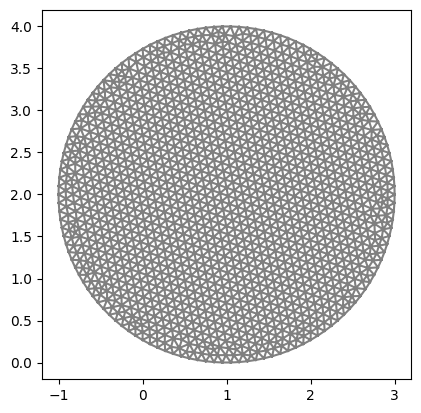

In [44]:
filename = "mesh/circleMesh2"
mesh = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh, filename + "_physical_region.xml")
plot(mesh)

Solving linear variational problem.


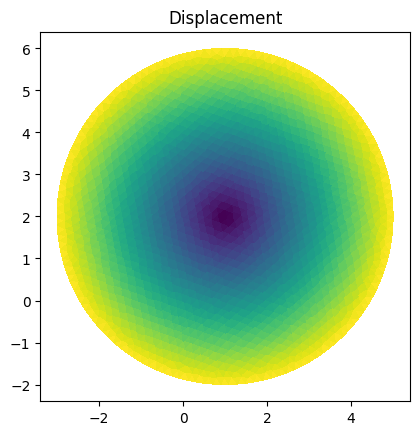

In [45]:
# Scaled variables
E = 1e5
nu = 0.3
mu = E / (2 * (1 + nu))
lambda_ = E * nu / ((1 + nu) * (1 - 2 * nu))

# Create mesh and define function space
V = VectorFunctionSpace(mesh, 'P', 1)

# Define boundary condition
tol = 1E-14

def clamped_boundary(x, on_boundary):
    return on_boundary and x[0] < tol
g = Expression(("2*(x[0]-1)/sqrt((x[0]-1)*(x[0]-1)+(x[1]-2)*(x[1]-2))", "2*(x[1]-2)/sqrt((x[0]-1)*(x[0]-1)+(x[1]-2)*(x[1]-2))"), degree=2)
bc = DirichletBC(V, g, bounds,1)

# Define strain and stress

def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)
    #return sym(nabla_grad(u))

def sigma(u):
    return lambda_*div(u)*Identity(d) + 2*mu*epsilon(u)

# Define variational problem
u = TrialFunction(V)
d = u.geometric_dimension() # space dimension
v = TestFunction(V)
f = Constant((0, 0))  # body force
T = Constant((0, 0))
q = 1e4
a = inner(sigma(u), epsilon(v))*dx
L = dot(f, v)*dx + dot(T, v)*ds

# Compute solution
uinit = Function(V)
solve(a == L, uinit, bc)
plot(uinit, title="Displacement", mode="displacement")

## Visco-elastic model

In [46]:
# parameters and util functions

E = 1e5
nu = 6*1e7
q = 3.09*1e5
fy = 4*1e-4
m = 10
Cf = 1e6
T = 1501
dt = 0.1
folder_path = "plots/eps0_1e-1long"

def coef(u):
    # print(norm(u))
    return fy*(1-exp(-m*norm(u)))/norm(u) + Cf

def sym_grad(u):
    return 0.5*(grad(u) + grad(u).T)

def antisym_grad(u):
    return 0.5*(grad(u) - grad(u).T)

def sigma(u,eps):
    return 2*nu*sym_grad(u) + 2*E*eps


In [47]:
# sol = plot(eps[0,0]**2 + eps[1,1]**2 + eps[0,1]**2 + eps[1,0]**2)
# plt.colorbar(sol)

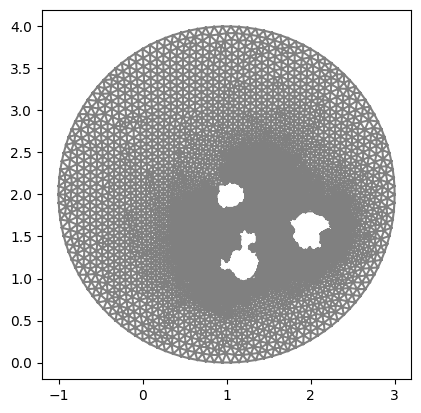

In [48]:
# Create mesh

filename = "mesh/mesh_from_image"
mesh_init = Mesh(filename + ".xml")
bounds = MeshFunction("size_t", mesh_init, filename + "_facet_region.xml")
face = MeshFunction("size_t", mesh_init, filename + "_physical_region.xml")
plot(mesh_init)

In [49]:
# Create function spaces

V = VectorElement("P", mesh_init.ufl_cell(), 1)
Q = TensorElement("P", mesh_init.ufl_cell(), 1)
W = FunctionSpace(mesh_init,V*Q)

# Define boundary condition

bc_out = DirichletBC(W.sub(0), Constant((0,0)), bounds, 1)
# g = Expression(("-0.01*(x[0]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))", "-0.01*(x[1]+0.4)/sqrt((x[0]+0.4)*(x[0]+0.4)+(x[1]+0.4)*(x[1]+0.4))"), degree=2)
# bc_in = DirichletBC(W.sub(0), g, bounds, 4)
bcs = [bc_out] #, bc_in]

# Define variational problem

# uinit = interpolate(uinit, W.sub(0).collapse())
eps0 = project(Identity(d)*1e-1,W.sub(1).collapse())
u0 = interpolate(Constant((0,0)), W.sub(0).collapse())
# f = Constant((0,0))
for t in range(T):
    print(f'Iteration {t}')
    utrial,epstrial = TrialFunctions(W)
    v,w = TestFunctions(W)
    
    a_sigma = inner(2*nu*sym_grad(utrial), sym_grad(v))*dx + q*inner(utrial,v)*dx + inner(E*epstrial, grad(v))*dx \
            + inner(E*epstrial,grad(v).T)*dx
    a_eps = (1/dt)*inner(epstrial, w)*dx + inner(dot(u0,grad(epstrial)), w)*dx  + inner(dot(epstrial,antisym_grad(u0)),w)*dx \
            - inner(dot(antisym_grad(u0),epstrial),w)*dx + inner(dot(sym_grad(u0),epstrial),w)*dx + inner(dot(epstrial,sym_grad(u0)),w)*dx \
            + inner(sym_grad(utrial),w)*dx
    L_eps = (1/dt)*inner(eps0, w)*dx 

    a = a_sigma + a_eps
    L = L_eps
    U = Function(W)
    solve(a == L, U, bcs=bcs, solver_parameters={'linear_solver' : 'mumps'})
    u, eps = U.split()
    if t % 10 == 0:
        # sol = plot(u,mode='displacement')
        # plt.colorbar(sol)
        # plt.title(f'Displacement at iteration {t}')
        # plt.savefig(f'{folder_path}/{t}.png')
        # # plt.show()
        # plt.close()
    # mesh update
    # u0.assign(u)
        sigma = nu*grad(u) + nu*grad(u).T + 2*E*eps

        # cax1 = plot(sigma[0,0])#, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
        # plt.title('Sforzo $\sigma_{xx}$')
        # plt.colorbar(cax1)
        # plt.savefig(f'{folder_path}/stressxx/{t}.png')
        # plt.close()
        # cax2 = plot(sigma[1,1])#, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
        # plt.title('Sforzo $\sigma_{yy}$')
        # plt.colorbar(cax2)
        # plt.savefig(f'{folder_path}/stressyy/{t}.png')
        # plt.close()
        # cax3 = plot(sigma[0,1])#, extent=[0, 1, 0, 1], origin='lower', cmap='viridis')
        # plt.title('Sforzo $\sigma_{xy}$')
        # plt.colorbar(cax3)
        # plt.savefig(f'{folder_path}/stressxy/{t}.png')
        # plt.close()
        # cax4 = plot(sigma[1,0])
        # plt.title('Sforzo $\sigma_{yx}$')
        # plt.colorbar(cax4)
        # plt.savefig(f'{folder_path}/stressyx/{t}.png')
        # plt.close()
        sigma_norm = sqrt(sigma[0,0]**2 + sigma[1,1]**2 + sigma[0,1]**2 + sigma[1,0]**2)
        cax5 = plot(sigma_norm)
        plt.title('Sigma norm')
        plt.colorbar(cax5)
        plt.savefig(f'{folder_path}/stressnorm/{t}.png')
        plt.close()

        # plot(mesh_init, linewidth=0.1)
        # plt.title(f'Mesh at iteration {t}')
        # plt.savefig(f'{folder_path}/{t}.png', dpi=400)
        # plt.close()

    ALE.move(mesh_init, u)
    V = VectorElement("P", mesh_init.ufl_cell(), 1)
    Q = TensorElement("P", mesh_init.ufl_cell(), 1)
    W = FunctionSpace(mesh_init,V*Q)

    u0 = interpolate(u, W.sub(0).collapse())
    eps0 = interpolate(eps, W.sub(1).collapse())
    
    bc_in = DirichletBC(W.sub(0), g, bounds, 4)
    bc_out = DirichletBC(W.sub(0), Constant((0,0)), bounds, 1)
    bcs = [bc_out] #, bc_in]


Iteration 0
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.
Iteration 1
Solving linear variational problem.
Iteration 2
Solving linear variational problem.
Iteration 3
Solving linear variational problem.
Iteration 4
Solving linear variational problem.
Iteration 5
Solving linear variational problem.
Iteration 6
Solving linear variational problem.
Iteration 7
Solving linear variational problem.
Iteration 8
Solving linear variational problem.
Iteration 9
Solving linear variational problem.
Iteration 10
Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.
Iteration 11
Solving linear variational problem.
Iteration 12
Solving linear variational problem.
Iteration 13
Solving linear variational problem.
Iteration 14
Solving linear variational problem.
Iteration 15
Solving linear variational problem.
Iteration 16
Solving linear variational problem.
Iteration 17
Solving linear variational p

In [50]:
import cv2
import os
import re 

def extract_number(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else -1

# Cartella contenente le immagini
images_folder = f"{folder_path}/stressnorm"

# Elenco delle immagini nella cartella
image_files = [img for img in os.listdir(images_folder) if img.endswith(".jpg") or img.endswith(".png")]

# Ordina le immagini in base al loro nome
image_files.sort(key=extract_number)

# Verifica che ci siano immagini nella cartella
if not image_files:
    print("Non ci sono immagini nella cartella.")
    exit()

# Carica la prima immagine per ottenere le dimensioni del frame
first_image_path = os.path.join(images_folder, image_files[0])
first_image = cv2.imread(first_image_path)

if first_image is None:
    print("Impossibile caricare l'immagine:", first_image_path)
    exit()

frame_height, frame_width, _ = first_image.shape

# Crea un oggetto VideoWriter
output_video_path = f'{images_folder}/video_ouutput2.avi'
video = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'MJPG'), 1, (frame_width, frame_height))

# Itera sulle immagini e scrivile nel video
for image_file in image_files:
    img_path = os.path.join(images_folder, image_file)
    img = cv2.imread(img_path)

    if img is None:
        print("Impossibile caricare l'immagine:", img_path)
        continue

    # Verifica che l'immagine abbia le stesse dimensioni del frame
    if img.shape[1] != frame_width or img.shape[0] != frame_height:
        print("Le dimensioni dell'immagine non corrispondono:", img_path)
        continue

    video.write(img)

# Chiudi il video
video.release()

print(f"Video creato con successo! Salvato come {output_video_path}")

Video creato con successo! Salvato come plots/eps0_1e-1long/stressnorm/video_ouutput2.avi


In [51]:
import json

# Definisci i parametri che vuoi salvare
if q == None:
    parametri = {
        "E": E,
        "nu": nu,
        "fy": fy,
        "m": m,
        "Cf": Cf,
    }
else:
    parametri = {
        "E": E,
        "nu": nu,
        "q": q,
    }

# Nome del file JSON in cui salvare i parametri
nome_file = f'{folder_path}/parametri.json'

# Salva i parametri in un file JSON
with open(nome_file, 'w') as file_json:
    json.dump(parametri, file_json, indent=4)

print(f"Parametri salvati in {nome_file}")


Parametri salvati in plots/eps0_1e-1long/parametri.json
